# Image Captioning - Legenda Automática para Imagens

Este notebook implementa um modelo de geração de legendas para imagens usando CNN (encoder) + LSTM (decoder).

## 1. Importações e Configurações Iniciais

### 1.1 Imports básicos

Bibliotecas fundamentais para manipulação de arquivos JSON, expressões regulares, sistema de arquivos e argumentos de linha de comando.

In [130]:
import json
import re
import os
import argparse

### 1.2 Imports de manipulação de dados

NumPy para operações numéricas, Pandas para análise de dados tabulares e Counter para contagem de palavras no vocabulário.

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

### 1.3 Imports de processamento de imagem

PIL para carregar imagens e torchvision para transformações de imagem e modelos pré-treinados (ResNet50).

In [132]:
from PIL import Image
from torchvision import transforms, models

### 1.4 Imports do PyTorch

Framework principal para deep learning: tensores, módulos de redes neurais e utilidades para criação de datasets e dataloaders.

In [133]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### 1.5 Imports de NLP e visualização

NLTK para tokenização de texto, Matplotlib para plotar gráficos e TQDM para barras de progresso durante o treinamento.

In [134]:
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm

### 1.6 Definição de tokens especiais

Tokens especiais usados no processamento de sequências: PAD (padding), BOS (início), EOS (fim) e UNK (desconhecido).

In [135]:
PAD = "<pad>"  # Padding token
BOS = "<bos>"  # Begin of sentence
EOS = "<eos>"  # End of sentence
UNK = "<unk>"  # Unknown token

## 2. Classe Vocabulary

### 2.1 Integrar métodos na classe Vocabulary



Gerencia o vocabulário do modelo. Constrói mapeamentos palavra↔ID a partir do dataset, codifica texto em IDs e decodifica IDs de volta para texto. Também permite salvar/carregar o vocabulário.

In [136]:
class Vocabulary:
    def __init__(self, min_freq=3):
        self.min_freq = min_freq
        self.word2id = {PAD: 0, BOS: 1, EOS: 2, UNK: 3}
        self.id2word = {0: PAD, 1: BOS, 2: EOS, 3: UNK}

    def build(self, texts):
        tok = lambda s: nltk.word_tokenize(re.sub(r"[^A-Za-z0-9' ]", " ", s.lower()))
        cnt = Counter()
        for t in texts:
            cnt.update(tok(t))
        for w, c in cnt.items():
            if c >= self.min_freq and w not in self.word2id:
                idx = len(self.word2id)
                self.word2id[w] = idx
                self.id2word[idx] = w

    def encode(self, text, max_len=20):
        tok = nltk.word_tokenize(re.sub(r"[^A-Za-z0-9' ]", " ", text.lower()))
        ids = [self.word2id.get(w, self.word2id[UNK]) for w in tok][:max_len]
        return [self.word2id[BOS]] + ids + [self.word2id[EOS]]

    def decode(self, ids):
        words = []
        for i in ids:
            w = self.id2word.get(int(i), UNK)
            if w in [PAD, BOS]:
                continue
            if w == EOS:
                break
            words.append(w)
        return " ".join(words)

    def to_json(self, path):
        with open(path, "w", encoding="utf-8") as f:
            json.dump({"min_freq": self.min_freq, "word2id": self.word2id}, f)

    @classmethod
    def from_json(cls, path):
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)
        v = cls(min_freq=obj["min_freq"])
        v.word2id = obj["word2id"]
        v.id2word = {int(i): w for w, i in [(i, w) for w, i in v.word2id.items()]}
        return v

## 3. Dataset e Collate Function

### 3.1 Classe CaptionDataset completa

Dataset PyTorch customizado que carrega imagens e suas legendas. Aplica transformações nas imagens (resize, normalização) e codifica as legendas em sequências de IDs de tokens.

In [137]:
class CaptionDataset(Dataset):
    def __init__(self, df, images_root, vocab, split="train", max_len=20, image_size=224):
        self.df = df[df["split"] == split].reset_index(drop=True)
        self.images_root = images_root
        self.vocab = vocab
        self.max_len = max_len
        self.tf = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_root, row['image_path'])
        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            raise FileNotFoundError(f"Imagem não encontrada: {img_path}")       
        img = self.tf(img)
        ids = self.vocab.encode(row["caption"], max_len=self.max_len)
        return img, torch.tensor(ids, dtype=torch.long)

### 3.2 Função pad_collate (para DataLoader)

Função de collate customizada que agrupa múltiplos samples em batches, fazendo padding das sequências de legendas para que todas tenham o mesmo tamanho.

In [138]:
def pad_collate(batch):
    imgs, seqs = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    
    lengths = [len(s) for s in seqs]
    maxlen = max(lengths)
    PAD_ID = 0
    
    padded = torch.full((len(seqs), maxlen), PAD_ID, dtype=torch.long)
    for i, s in enumerate(seqs):
        padded[i, :len(s)] = s
    
    return imgs, padded, torch.tensor(lengths, dtype=torch.long)

## 4. Função de Avaliação (BLEU Score)

Calcula o BLEU score para avaliar a qualidade das legendas geradas comparando-as com as referências. Usa a biblioteca sacrebleu para cálculo robusto.

In [139]:
def compute_bleu(gens, refs):
    import sacrebleu

    bleu = sacrebleu.corpus_bleu(
        gens,
        [refs]   # sacrebleu espera lista de referências
    )
    return bleu.score / 100.0

Célula de teste simples para verificar se a função compute_bleu está funcionando corretamente com exemplos básicos.

In [140]:
gens = ["a boy is playing"]
refs = ["a child is playing"]

print(compute_bleu(gens, refs))


0.35355339059327373


## 5. Modelos (Encoder e Decoder)

### 5.1 EncoderCNN - Classe completa
Encoder baseado em CNN que extrai features visuais das imagens usando ResNet50 pré-treinada. A camada final projeta as features para o espaço de embedding.

In [141]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        for p in backbone.parameters():
            p.requires_grad = False
        modules = list(backbone.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        self.fc = nn.Linear(backbone.fc.in_features, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            feats = self.cnn(images).squeeze()
            if feats.dim() == 1:
                feats = feats.unsqueeze(0)
        return self.bn(self.fc(feats))

### 5.2 DecoderLSTM - Inicialização
Decoder LSTM que gera legendas palavra por palavra. Recebe as features da imagem e usa teacher forcing durante treinamento. O método sample() gera legendas autorregressivamente durante inferência. 

In [142]:
class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=1, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        if features.dim() == 2:
            features = features.unsqueeze(1)
        inputs = torch.cat([features, embeds], dim=1)
        lstm_out, _ = self.lstm(inputs)
        outputs = self.fc_out(lstm_out)
        return outputs[:, :-1, :]

    def sample(self, features, max_len=20, bos_id=1, eos_id=2):
        batch_size = features.size(0)
        result = []
        inputs = features.unsqueeze(1)
        states = None
        for _ in range(max_len):
            lstm_out, states = self.lstm(inputs, states)
            outputs = self.fc_out(lstm_out.squeeze(1))
            predicted = outputs.argmax(dim=1)
            result.append(predicted.unsqueeze(1))
            inputs = self.embedding(predicted).unsqueeze(1)
        return torch.cat(result, dim=1)

## 6. Funções de Visualização

### 6.1 Plot de curvas de loss

Função para plotar as curvas de loss de treinamento e validação ao longo das épocas, salvando o gráfico em arquivo.

In [143]:
def plot_curves(history, outpath):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(history["train_loss"], label="train_loss")
    ax.plot(history["val_loss"], label="val_loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss (CE)")
    ax.set_title("Training & Validation Loss")
    ax.legend()
    fig.tight_layout()
    fig.savefig(outpath, dpi=160)
    plt.close(fig)

### 6.2 Plot de BLEU scores

Função para plotar a evolução do BLEU score durante o treinamento, permitindo visualizar a melhoria da qualidade das legendas.

In [144]:
def plot_bleu(bleus, outpath):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(bleus, label="BLEU-4")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("BLEU")
    ax.set_title("Validation BLEU-4")
    ax.legend()
    fig.tight_layout()
    fig.savefig(outpath, dpi=160)
    plt.close(fig)

## 7. Configuração e Preparação dos Dados

### 7.1 Configurar argumentos/parâmetros

Define todos os hiperparâmetros do treinamento: caminhos de arquivos, número de épocas, tamanho do batch, dimensões dos embeddings, learning rate, etc.

In [145]:
captions_csv = "captions_split.csv"
images_root = "data/images"
outdir = "outputs"
epochs = 10
batch_size = 128
embed_dim = 256
hidden_dim = 512
min_freq = 3
max_len = 20
lr = 1e-3
seed = 42

### 7.2 Criar diretório de saída e definir seed

Cria o diretório de saída para salvar modelos e gráficos. Define seeds para reprodutibilidade dos resultados.

In [147]:
os.makedirs(outdir, exist_ok=True)
torch.manual_seed(seed)
np.random.seed(seed)

### 7.3 Carregar dados e construir vocabulário

Carrega o CSV com as legendas, constrói o vocabulário a partir das legendas de treino e salva o vocabulário para uso posterior na inferência.

In [148]:
df = pd.read_csv(captions_csv)
vocab = Vocabulary(min_freq=min_freq)
vocab.build(df[df["split"] == "train"]["caption"].tolist())
vocab.to_json(os.path.join(outdir, "vocab.json"))

print(f"Tamanho do vocabulário: {len(vocab.word2id)}")

Tamanho do vocabulário: 3431


Foi definida uma amostra menor para que o tempo de treinamento diminuisse

In [ ]:
df = df.sample(4500, random_state=42)
vocab = Vocabulary(min_freq=min_freq)
vocab.build(df[df["split"] == "train"]["caption"].tolist())

### 7.4 Criar datasets

Cria os datasets de treino e validação usando a classe CaptionDataset, filtrando automaticamente pelos splits definidos no CSV.

In [150]:
train_ds = CaptionDataset(df, images_root, vocab, split="train", max_len=max_len)
val_ds = CaptionDataset(df, images_root, vocab, split="val", max_len=max_len)

print(f"Dataset de treino: {len(train_ds)} amostras")
print(f"Dataset de validação: {len(val_ds)} amostras")

Dataset de treino: 3133 amostras
Dataset de validação: 687 amostras


### 7.5 Criar dataloaders

Cria os dataloaders que irão fornecer batches durante o treinamento, com shuffling no treino e usando a função pad_collate customizada.

In [ ]:
train_dl = DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=pad_collate, 
    num_workers=0 
)

val_dl = DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=pad_collate, 
    num_workers=0 
)

## 8. Inicialização do Modelo

### 8.1 Configurar device

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

Usando device: cpu


### 8.2 Criar encoder e decoder

In [153]:
enc = EncoderCNN(embed_dim=embed_dim).to(device)
dec = DecoderLSTM(vocab_size=len(vocab.word2id), 
                  embed_dim=embed_dim, 
                  hidden_dim=hidden_dim).to(device)

print("Modelos criados com sucesso!")

Modelos criados com sucesso!


### 8.3 Configurar loss e optimizer

In [154]:
crit = nn.CrossEntropyLoss(ignore_index=0)
params = list(dec.parameters()) + list(enc.fc.parameters()) + list(enc.bn.parameters())
opt = torch.optim.Adam(params, lr=lr)

print(f"Número total de parâmetros treináveis: {sum(p.numel() for p in params if p.requires_grad)}")

Número total de parâmetros treináveis: 2855636


## 9. Loop de Treinamento

### 9.1 Inicializar histórico

Cria dicionário para armazenar métricas (loss de treino/validação e BLEU) ao longo das épocas. Inicializa variável para rastrear o melhor modelo.

In [155]:
history = {"train_loss": [], "val_loss": [], "bleu4": []}
best_bleu = -1.0

### 9.2 Loop principal de treinamento

Loop de treinamento completo que:

Treina o modelo com teacher forcing
Avalia no conjunto de validação
Calcula BLEU score
Salva o melhor modelo
Plota curvas de aprendizado

In [156]:
for ep in range(1, epochs + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {ep}/{epochs}")
    print(f"{'='*60}")
    
    # =========================================================================
    # TREINAMENTO
    # =========================================================================
    enc.train()
    dec.train()
    tr_loss = 0.0
    n = 0
    
    for imgs, tgt, lengths in tqdm(train_dl, desc=f"Treinamento"):
        imgs, tgt = imgs.to(device), tgt.to(device)
        
        opt.zero_grad()
        feats = enc(imgs)
        logits = dec(feats, tgt[:, :-1])
        
        # ✅ CORREÇÃO AQUI: tgt.reshape(-1) → tgt[:, 1:].reshape(-1)
        loss = crit(logits.reshape(-1, logits.size(-1)), tgt[:, 1:].reshape(-1))
        
        loss.backward()
        opt.step()
        
        tr_loss += loss.item() * imgs.size(0)
        n += imgs.size(0)
    
    tr = tr_loss / n
    print(f"Train Loss: {tr:.4f}")
    
    # =========================================================================
    # VALIDAÇÃO
    # =========================================================================
    enc.eval()
    dec.eval()
    va_loss = 0.0
    vn = 0
    gens, refs = [], []
    
    with torch.no_grad():
        for imgs, tgt, lengths in tqdm(val_dl, desc=f"Validação"):
            imgs, tgt = imgs.to(device), tgt.to(device)
            feats = enc(imgs)
            logits = dec(feats, tgt[:, :-1])
            
            # ✅ CORREÇÃO AQUI: tgt.reshape(-1) → tgt[:, 1:].reshape(-1)
            loss = crit(logits.reshape(-1, logits.size(-1)), tgt[:, 1:].reshape(-1))
            
            va_loss += loss.item() * imgs.size(0)
            vn += imgs.size(0)
            
            out_ids = dec.sample(feats, max_len=max_len)
            for i in range(out_ids.size(0)):
                gens.append(vocab.decode(out_ids[i].cpu().numpy()))
                refs.append(vocab.decode(tgt[i, 1:].cpu().numpy()))
    
    vl = va_loss / vn
    bleu4 = compute_bleu(gens, refs)
    
    print(f"Val Loss: {vl:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    
    # =========================================================================
    # SALVAMENTO
    # =========================================================================
    history["train_loss"].append(tr)
    history["val_loss"].append(vl)
    history["bleu4"].append(bleu4)
    
    if bleu4 > best_bleu:
        best_bleu = bleu4
        torch.save({
            "encoder": enc.state_dict(),
            "decoder": dec.state_dict(),
            "vocab_size": len(vocab.word2id),
            "embed_dim": embed_dim,
            "hidden_dim": hidden_dim,
            "max_len": max_len
        }, os.path.join(outdir, "best_captioner.pt"))
        print(f"✓ Melhor modelo salvo! (BLEU-4: {bleu4:.4f})")
    
    plot_curves(history, os.path.join(outdir, "training_curves.png"))
    plot_bleu(history["bleu4"], os.path.join(outdir, "bleu_scores.png"))


Epoch 1/10


Treinamento: 100%|██████████| 25/25 [07:38<00:00, 18.33s/it]


Train Loss: 5.4335


Validação: 100%|██████████| 6/6 [01:31<00:00, 15.21s/it]


Val Loss: 4.7090
BLEU-4: 0.0191
✓ Melhor modelo salvo! (BLEU-4: 0.0191)

Epoch 2/10


Treinamento: 100%|██████████| 25/25 [07:13<00:00, 17.32s/it]


Train Loss: 4.4879


Validação: 100%|██████████| 6/6 [01:25<00:00, 14.25s/it]


Val Loss: 4.2821
BLEU-4: 0.0302
✓ Melhor modelo salvo! (BLEU-4: 0.0302)

Epoch 3/10


Treinamento: 100%|██████████| 25/25 [07:12<00:00, 17.29s/it]


Train Loss: 4.1405


Validação: 100%|██████████| 6/6 [01:24<00:00, 14.08s/it]


Val Loss: 4.0448
BLEU-4: 0.0639
✓ Melhor modelo salvo! (BLEU-4: 0.0639)

Epoch 4/10


Treinamento: 100%|██████████| 25/25 [07:05<00:00, 17.03s/it]


Train Loss: 3.9159


Validação: 100%|██████████| 6/6 [01:24<00:00, 14.07s/it]


Val Loss: 3.9071
BLEU-4: 0.0501

Epoch 5/10


Treinamento: 100%|██████████| 25/25 [07:06<00:00, 17.08s/it]


Train Loss: 3.7522


Validação: 100%|██████████| 6/6 [01:24<00:00, 14.08s/it]


Val Loss: 3.8305
BLEU-4: 0.0599

Epoch 6/10


Treinamento: 100%|██████████| 25/25 [07:05<00:00, 17.01s/it]


Train Loss: 3.6098


Validação: 100%|██████████| 6/6 [01:25<00:00, 14.28s/it]


Val Loss: 3.7650
BLEU-4: 0.0491

Epoch 7/10


Treinamento: 100%|██████████| 25/25 [07:04<00:00, 16.99s/it]


Train Loss: 3.4845


Validação: 100%|██████████| 6/6 [01:24<00:00, 14.04s/it]


Val Loss: 3.7268
BLEU-4: 0.0505

Epoch 8/10


Treinamento: 100%|██████████| 25/25 [07:03<00:00, 16.94s/it]


Train Loss: 3.3645


Validação: 100%|██████████| 6/6 [01:24<00:00, 14.11s/it]


Val Loss: 3.7048
BLEU-4: 0.0581

Epoch 9/10


Treinamento: 100%|██████████| 25/25 [07:12<00:00, 17.29s/it]


Train Loss: 3.2453


Validação: 100%|██████████| 6/6 [01:24<00:00, 14.16s/it]


Val Loss: 3.6738
BLEU-4: 0.0551

Epoch 10/10


Treinamento: 100%|██████████| 25/25 [07:05<00:00, 17.02s/it]


Train Loss: 3.1310


Validação: 100%|██████████| 6/6 [01:25<00:00, 14.27s/it]


Val Loss: 3.6592
BLEU-4: 0.0702
✓ Melhor modelo salvo! (BLEU-4: 0.0702)


### 9.3 Salvar métricas finais

In [157]:
with open(os.path.join(outdir, "metrics.json"), "w") as f:
    json.dump({"best_bleu4": best_bleu}, f, indent=2)

print(f"\n{'='*60}")
print(f"Treinamento concluído!")
print(f"Melhor BLEU-4: {best_bleu:.4f}")
print(f"{'='*60}")


Treinamento concluído!
Melhor BLEU-4: 0.0702


## 10. Inferência (Geração de Legendas)

### 10.1 Função auxiliar para carregar vocabulário

Função auxiliar para carregar o vocabulário salvo durante o treinamento, reconstruindo os mapeamentos palavra↔ID.

In [158]:
def load_vocab(path):
    """Carrega vocabulário salvo durante o treinamento"""
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)
    v = Vocabulary(min_freq=obj.get("min_freq", 3))
    v.word2id = obj["word2id"]
    v.id2word = {int(i): w for w, i in v.word2id.items()}
    return v

### 10.2 Configurar caminhos para inferência

Define os caminhos do modelo treinado, vocabulário e imagem de teste. Permite escolher entre imagens do dataset ou imagens customizadas.

In [159]:
checkpoint_path = "outputs/best_captioner.pt"
vocab_path = "outputs/vocab.json"
df_val = df[df["split"] == "val"]
sample_idx = 0  # Mude este número para testar outras imagens (0, 1, 2, 3...)
image_path = os.path.join(images_root, df_val.iloc[sample_idx]["image_path"])
reference_caption = df_val.iloc[sample_idx]["caption"]

print(f"\n Configuração:")
print(f"   Modelo: {checkpoint_path}")
print(f"   Imagem: {image_path}")
print(f"   Legenda original: '{reference_caption}'")
max_len_infer = 20


 Configuração:
   Modelo: outputs/best_captioner.pt
   Imagem: data/images\2659183350_730951f740.jpg
   Legenda original: 'A kid kicking a large ball while surrounded by other kids .'


### 10.3 Carregar modelo treinado

Carrega o checkpoint do melhor modelo salvo, recria encoder e decoder com as mesmas configurações e restaura os pesos treinados.

In [160]:
device_infer = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(checkpoint_path, map_location=device_infer)
vocab_infer = load_vocab(vocab_path)

# Criar encoder e decoder com as mesmas configurações do treinamento
enc_infer = EncoderCNN(embed_dim=ckpt["embed_dim"]).to(device_infer)
dec_infer = DecoderLSTM(
    vocab_size=ckpt["vocab_size"], 
    embed_dim=ckpt["embed_dim"], 
    hidden_dim=ckpt["hidden_dim"]
).to(device_infer)

# Carregar pesos salvos
enc_infer.load_state_dict(ckpt["encoder"])
dec_infer.load_state_dict(ckpt["decoder"])
enc_infer.eval()
dec_infer.eval()

DecoderLSTM(
  (embedding): Embedding(980, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc_out): Linear(in_features=512, out_features=980, bias=True)
)

### 10.4 Preparar transformação de imagem

Define as mesmas transformações de imagem usadas no treinamento (resize, normalização) para garantir consistência.

In [161]:
tf_infer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### 10.5 Gerar legenda para uma imagem

Carrega a imagem, processa através do encoder para extrair features e usa o decoder para gerar a legenda palavra por palavra.

In [162]:
img = Image.open(image_path).convert("RGB")
img_tensor = tf_infer(img).unsqueeze(0).to(device_infer)

# Gerar legenda
with torch.no_grad():
    feats = enc_infer(img_tensor)
    ids = dec_infer.sample(
        feats, 
        max_len=max_len_infer, 
        bos_id=vocab_infer.word2id["<bos>"], 
        eos_id=vocab_infer.word2id["<eos>"]
    )

# Decodificar IDs para texto
generated_caption = vocab_infer.decode(ids[0].cpu().numpy())


### 10.6 Visualizar imagem com legenda


RESULTADO

  Imagem: 2891961886_b7a2f0b0fd.jpg
Legenda original:  A kid kicking a large ball while surrounded by other kids .
Legenda gerada:    happily wheelchair and <unk>


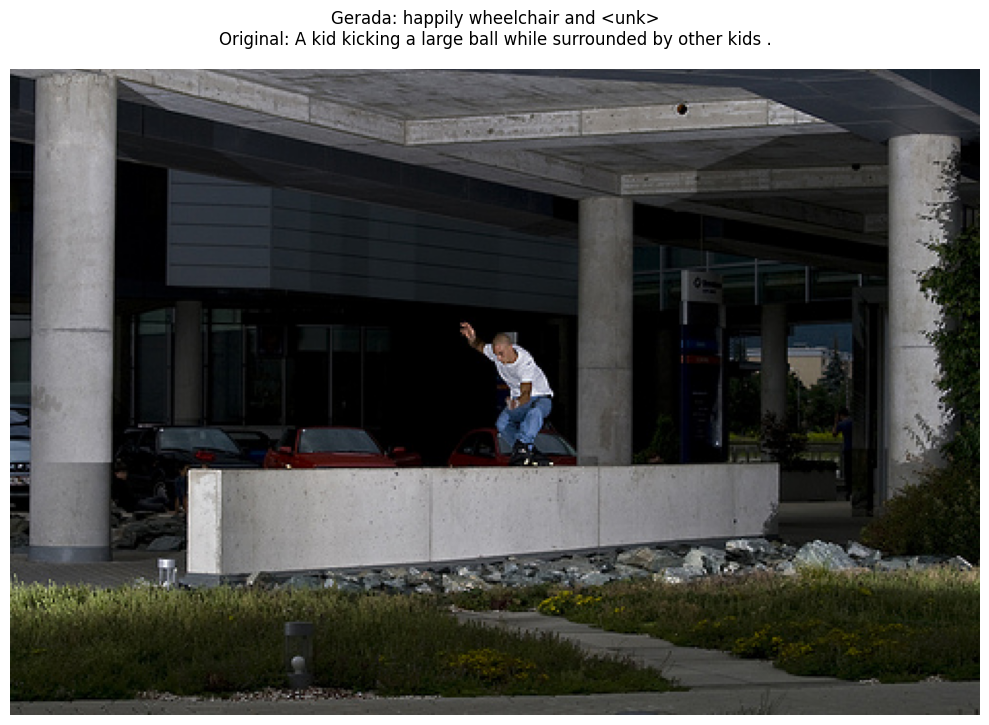

In [167]:
print(f"\n{'='*70}")
print(f"RESULTADO")
print(f"{'='*70}")
print(f"\n  Imagem: {os.path.basename(image_path)}")
if reference_caption:
    print(f"Legenda original:  {reference_caption}")
print(f"Legenda gerada:    {generated_caption}")
print(f"{'='*70}")

# Plotar imagem com legenda
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img)
title = f"Gerada: {generated_caption}"
if reference_caption:
    title += f"\nOriginal: {reference_caption}"
ax.set_title(title, fontsize=12, wrap=True, pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

In [166]:
for i in range(5):  # Testar 5 imagens
    image_path = os.path.join(images_root, df_val.iloc[i]["image_path"])
    reference = df_val.iloc[i]["caption"]
    
    img = Image.open(image_path).convert("RGB")
    img_tensor = tf_infer(img).unsqueeze(0).to(device_infer)
    
    with torch.no_grad():
        feats = enc_infer(img_tensor)
        ids = dec_infer.sample(feats, max_len=max_len_infer, 
                              bos_id=vocab_infer.word2id["<bos>"], 
                              eos_id=vocab_infer.word2id["<eos>"])
    
    caption = vocab_infer.decode(ids[0].cpu().numpy())
    
    print(f"\\n[{i+1}] Imagem: {df_val.iloc[i]['image_path']}")
    print(f"    Original: {reference}")
    print(f"    Gerada:   {caption}")

\n[1] Imagem: 2659183350_730951f740.jpg
    Original: A kid kicking a large ball while surrounded by other kids .
    Gerada:   happily wheelchair and <unk>
\n[2] Imagem: 542179694_e170e9e465.jpg
    Original: A firetruck stops and makes a call at a bridge , where a man and his dogs are running .
    Gerada:   orange wearing
\n[3] Imagem: 3486831913_2b9390ebbc.jpg
    Original: a brown dog wearing a blue collar is running on the grass .
    Gerada:   orange lights orange little smile
\n[4] Imagem: 2698119128_62b4741043.jpg
    Original: A girl enjoys the swimming pool .
    Gerada:   orange little together orange little
\n[5] Imagem: 2891961886_b7a2f0b0fd.jpg
    Original: Man skates along cement wall .
    Gerada:   orange orange little <unk> orange
